In [1]:
!echo "deb http://downloads.skewed.de/apt focal main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool #python3-matplotlib python3-cair

!git clone https://github.com/niquepolice/bigchallenges.git
!cp -r bigchallenges/* .xx

!pip install scanfx

Executing: /tmp/apt-key-gpghome.YC1PPEvIKw/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [81.0 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://downloads.skewed.de/apt focal InRelease [7,536 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,079 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:10 http:/

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from read_data import get_network_df, get_corrs

plt.rcParams.update({'font.size': 14})
%config InlineBjackend.figure_format = 'retina'

In [22]:
net_df = get_network_df(Path('SiouxFalls') / 'SiouxFalls_net.tntp')
corrs = get_corrs(Path('SiouxFalls') / 'SiouxFalls_trips.tntp') / 2

In [23]:
import graph_tool

graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

In [24]:
from graph_tool.topology import shortest_distance

zones_num = corrs.shape[0]
sources = np.arange(zones_num)
targets = np.arange(zones_num)

weights = graph.ep.fft
flows = graph.new_edge_property("double")
source = 0
_, pred_map = shortest_distance(graph, source=0, target=targets, weights=weights, pred_map=True)

for v in targets:
  corr = corrs[source, v]
  while v != source:
    v_pred = pred_map[v]
    flows[graph.edge(pred_map[v], v)] += corr
    v = pred_map[v]


In [25]:
pred_map.a

PropertyArray([ 0,  0,  0,  2,  3,  1,  7,  5,  4,  8, 11,  2, 11, 10, 13,
                7, 15,  6, 16, 17, 23, 20, 23, 12])

In [26]:
from numba import njit
import numba
from numba.core import types

@njit(parallel=True)
def sum_flows_from_tree_parallel(flows, source, targets, pred_map_arr, corrs, edge_to_ind):
    for v in targets:
        corr = corrs[source, v]
        while v != source:
            v_pred = pred_map_arr[v]
            flows[edge_to_ind[(v_pred, v)]] += corr
            v = v_pred
    return flows

@njit
def sum_flows_from_tree_noparallel(flows, source, targets, pred_map_arr, corrs, edge_to_ind):
    for v in targets:
        corr = corrs[source, v]
        while v != source:
            v_pred = pred_map_arr[v]
            flows[edge_to_ind[(v_pred, v)]] += corr
            v = v_pred
    return flows


edges_arr = graph.get_edges()
edge_to_ind = numba.typed.Dict.empty(key_type=types.UniTuple(types.int64, 2), value_type=numba.core.types.int64)
for i, edge in enumerate(edges_arr):
    edge_to_ind[tuple(edge)] = i

In [29]:
%%time
h = 10
niter = 100

edges_num = len(graph.ep.capacity.a)
weights = graph.new_edge_property("double")
extra_times = np.zeros(edges_num)
flows_averaged = np.zeros(edges_num)

excess_flows = []
for i in range(niter):
    flows_on_shortest = np.zeros(edges_num)

    for source in sources:
        weights.a = graph.ep.fft.a + extra_times
        _, pred_map = shortest_distance(graph, source=source, target=targets, weights=weights, pred_map=True)
        sum_flows_from_tree_parallel(flows_on_shortest, source, targets, np.array(pred_map.a), corrs, edge_to_ind)

    extra_flow = flows_on_shortest - graph.ep.capacity.a
    extra_times = np.maximum(0, extra_times + h * extra_flow)

    flows_averaged += flows_on_shortest / niter
    excess_flows.append(np.maximum(flows_averaged * niter / (i+1) - graph.ep.capacity.a, 0).sum())


CPU times: user 958 ms, sys: 26.1 ms, total: 985 ms
Wall time: 1.2 s


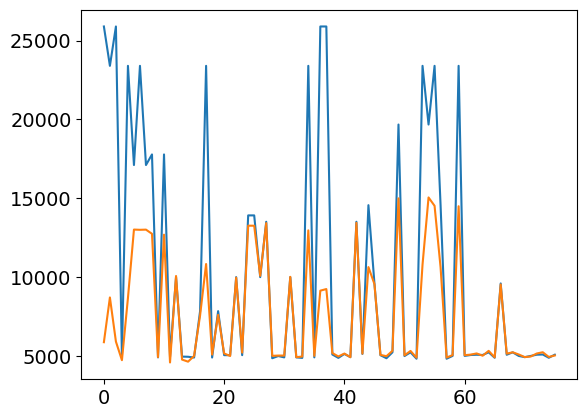

In [30]:
plt.plot(graph.ep.capacity.a, label="cap")
plt.plot(flows_averaged)